A edges: 35
유효 엣지 수: 35


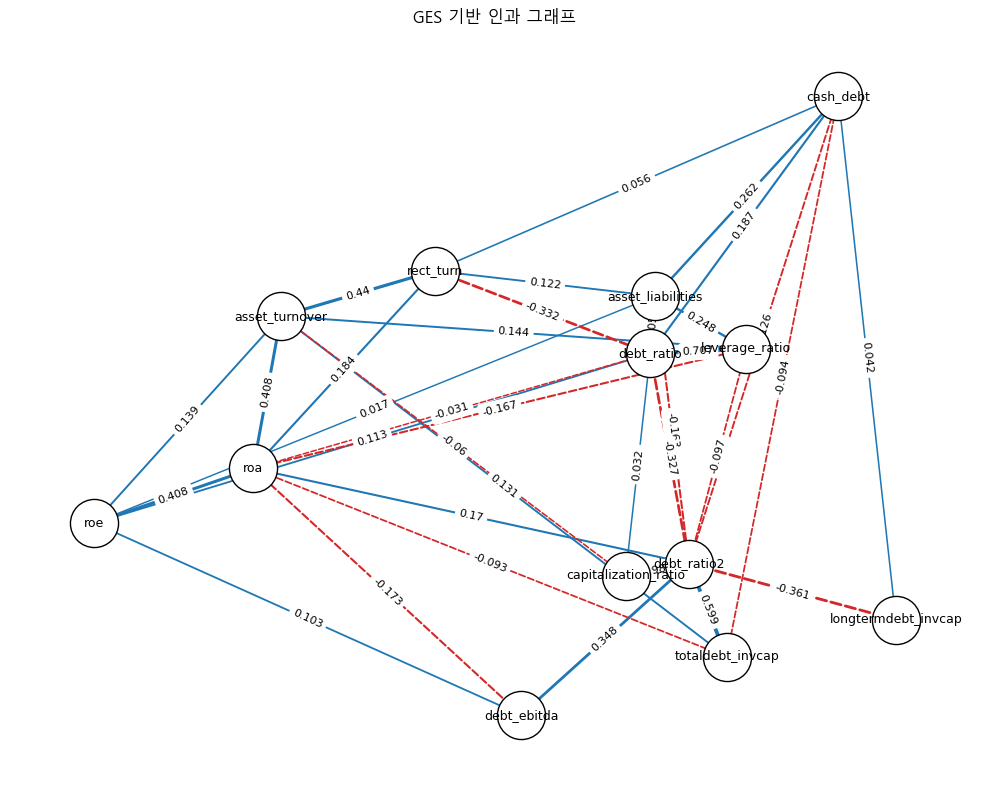

직접 자식 수: 3 → ['asset_turnover', 'debt_ratio', 'debt_ratio2']
계수 저장: scm_outputs\coeffs_capitalization_ratio.csv
회귀식 저장: scm_outputs\equations_capitalization_ratio.txt
[저장] 반복별 CSV: scm_outputs\synthetic\synthetic_capitalization_ratio_it0001.csv ... it0100.csv
[저장] 통합 CSV: scm_outputs\synthetic\synthetic_capitalization_ratio_all.csv (rows=1788100)
전파 대상 descendants (미리보기): ['asset_liabilities', 'asset_turnover', 'debt_ratio', 'debt_ratio2', 'roa', 'cash_debt', 'debt_ebitda']
위상정렬 (미리보기): ['capitalization_ratio', 'asset_turnover', 'roa', 'debt_ratio', 'asset_liabilities', 'debt_ratio2', 'cash_debt', 'debt_ebitda']
통합 CSV 경로: scm_outputs\synthetic\synthetic_capitalization_ratio_all.csv
[DEBUG] GES/OLS edges(|W|>1e-12 & A==1): 35, Xf_m: 25, Xf_mw: 24
[O-m-orig] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_col_wise=true` to remove t

AttributeError: 'FeatureDeltaStats' object has no attribute 'l2'

In [2]:
# rect_turn Weight Sweep Pipeline (GES → OLS → Features → CV → Sweep)
# 실행 순서:
# 1) 라이브러리 및 공통 설정
# 2) 데이터 로드 및 전처리
# 3) GES로 DAG 구조 학습
# 4) 표준화 OLS로 가중치 행렬 W 계산
# 5) 인과 그래프 시각화
# 6) 회귀식 및 잔차 저장 (scenario: capitalization_ratio)
# 7) do-개입 전파 시뮬레이션 (capitalization_ratio)
# 8) DAG 기반 파생 피처 생성 및 LGBM 교차검증
# 9) rect_turn 인접 엣지의 W 스케일 스윕 실험
# 10) 결과 저장 및 요약

import warnings
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Optional, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss
from lightgbm import LGBMClassifier

from causallearn.search.ScoreBased.GES import ges

# 시각화 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# 공통 하이퍼파라미터
RANDOM_STATE = 42
N_SPLITS = 10
PRINT_PROGRESS = True
TOP_K_EDGES = 25
W_EPS = 1e-12

# 데이터 로드
DATA_PATH = Path("training_data.csv")
assert DATA_PATH.exists(), f"파일이 없습니다: {DATA_PATH.resolve()}"
df = pd.read_csv(DATA_PATH)
assert "label" in df.columns, "'label' 컬럼이 필요합니다."
drop_cols = [c for c in ["Unnamed: 0"] if c in df.columns]
feature_cols = df.drop(columns=drop_cols + ["label"]).columns
X_base = df[feature_cols].copy()
y = df["label"].astype(int).copy()
cols = list(feature_cols)
X_np = X_base.values.astype(float)

# GES로 DAG 구조 학습
Record = ges(X_np)
Gmat = Record['G'].graph
p = len(cols)

# 방향성 인접행렬 A 정의: A[child, parent] = 1 이면 parent → child
A = np.zeros((p, p), dtype=float)
for i in range(p):
    for j in range(p):
        if i == j:
            continue
        if (Gmat[j, i] == 1) and (Gmat[i, j] == -1):
            A[j, i] = 1.0
print("A edges:", int(A.sum()))

# 표준화 OLS로 가중치 행렬 W 계산: W[child, parent]
Z = StandardScaler().fit_transform(X_np)
W = np.zeros_like(A, dtype=float)
for child in range(p):
    parents = np.where(A[child, :] == 1.0)[0]
    if parents.size == 0:
        continue
    y_child = Z[:, child]
    X_par = Z[:, parents]
    coef, *_ = np.linalg.lstsq(X_par, y_child, rcond=None)
    W[child, parents] = coef.astype(float)
edge_mask = (A == 1.0) & (np.abs(W) > W_EPS)
print("유효 엣지 수:", int(edge_mask.sum()))

# 인과 그래프 시각화
USE_QUANTILE = False
W_THRESHOLD = 0.01
W_ABS_QUANTILE = 0.90
TOP_K_EDGES_VIS = None

def get_threshold(W_, fixed=W_THRESHOLD, use_q=USE_QUANTILE, q=W_ABS_QUANTILE):
    if not use_q:
        return fixed
    aw = np.abs(W_).ravel()
    aw = aw[aw > 0]
    return float(np.quantile(aw, q)) if aw.size else fixed

thr = get_threshold(W)
edges_all = []
for i in range(p):
    for j in range(p):
        if i == j:
            continue
        w = float(W[i, j])
        if abs(w) > thr:
            edges_all.append((cols[j], cols[i], w))
if TOP_K_EDGES_VIS is not None and TOP_K_EDGES_VIS > 0 and len(edges_all) > TOP_K_EDGES_VIS:
    edges_all = sorted(edges_all, key=lambda t: abs(t[2]), reverse=True)[:TOP_K_EDGES_VIS]
G_draw = nx.DiGraph()
for u, v, w in edges_all:
    G_draw.add_edge(u, v, weight=round(w, 3))
eps = 1e-6
H = nx.Graph()
for u, v, d in G_draw.edges(data=True):
    w = d.get("weight", 0.0)
    dist = 1.0 / (abs(w) + eps)
    H.add_edge(u, v, weight=dist)
pos = nx.kamada_kawai_layout(H, weight='weight')
max_abs = max((abs(d["weight"]) for _, _, d in G_draw.edges(data=True)), default=1.0)
pos_edges = [(u, v) for u, v, d in G_draw.edges(data=True) if d["weight"] >= 0]
neg_edges = [(u, v) for u, v, d in G_draw.edges(data=True) if d["weight"] < 0]
pos_widths = [1.0 + 3.0 * abs(G_draw[u][v]["weight"]) / max_abs for u, v in pos_edges]
neg_widths = [1.0 + 3.0 * abs(G_draw[u][v]["weight"]) / max_abs for u, v in neg_edges]
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G_draw, pos, node_size=1200, node_color="white", edgecolors="black")
nx.draw_networkx_labels(G_draw, pos, font_size=9)
nx.draw_networkx_edges(G_draw, pos, edgelist=pos_edges, edge_color="tab:blue", width=pos_widths, arrows=True)
nx.draw_networkx_edges(G_draw, pos, edgelist=neg_edges, edge_color="tab:red",  width=neg_widths, style="dashed", arrows=True)
nx.draw_networkx_edge_labels(G_draw, pos, edge_labels=nx.get_edge_attributes(G_draw, 'weight'), font_size=8)
plt.title("GES 기반 인과 그래프")
plt.axis("off")
plt.tight_layout()
plt.show()

# 회귀식 및 잔차 저장 (scenario: capitalization_ratio)
OUT_DIR = Path("scm_outputs")
RESID_DIR = OUT_DIR / "residuals"
OUT_DIR.mkdir(parents=True, exist_ok=True)
RESID_DIR.mkdir(parents=True, exist_ok=True)
scenario_var = "capitalization_ratio"
if scenario_var not in cols:
    raise ValueError(f"{scenario_var} 가 컬럼에 없습니다.")
scenario_idx = cols.index(scenario_var)
children_idx = np.where(A[:, scenario_idx] == 1.0)[0]
children = [cols[i] for i in children_idx]
print(f"직접 자식 수: {len(children)} → {children}")
records = []
equations_lines = []
n = Z.shape[0]
for child in children_idx:
    parents = np.where(A[child, :] == 1.0)[0]
    if parents.size == 0:
        continue
    y_child = Z[:, child]
    X_par = Z[:, parents]
    coef, *_ = np.linalg.lstsq(X_par, y_child, rcond=None)
    y_hat = X_par @ coef
    resid = y_child - y_hat
    ss_res = float(np.sum(resid**2))
    ss_tot = float(np.sum(y_child**2)) + 1e-12
    r2 = 1.0 - ss_res / ss_tot
    child_name = cols[child]
    np.save(RESID_DIR / f"{child_name}.npy", resid)
    for p_idx, c in zip(parents, coef):
        records.append({
            "child": child_name,
            "parent": cols[p_idx],
            "coef": float(c),
            "r2": float(r2),
            "n_parents": int(parents.size)
        })
    parts = [f"{float(c):+.4f}·{cols[p_idx]}" for p_idx, c in zip(parents, coef)]
    eq = f"{child_name} = " + " ".join(parts) + f" + ε_{child_name}"
    equations_lines.append(eq)
if records:
    df_coef = pd.DataFrame(records).sort_values(["child", "parent"]).reset_index(drop=True)
    out_csv = OUT_DIR / f"coeffs_{scenario_var}.csv"
    df_coef.to_csv(out_csv, index=False, encoding="utf-8-sig")
    print("계수 저장:", out_csv)
    out_txt = OUT_DIR / f"equations_{scenario_var}.txt"
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write("# 회귀식 표준화, 절편 없음\n")
        f.write(f"# scenario_var = {scenario_var}\n\n")
        for line in equations_lines:
            f.write(line + "\n")
    print("회귀식 저장:", out_txt)
else:
    print("저장할 레코드가 없습니다.")

# do-개입 전파 시뮬레이션 (capitalization_ratio)
def simulate_do_capitalization_ratio(
    A, W, Z, cols, X_base, delta_raw=1.0, n_iter=100,
    residual_dir=Path("scm_outputs") / "residuals",
    use_bootstrap=True, random_state=42, save_each_iter=False,
    save_dir=Path("scm_outputs") / "synthetic"
):
    rng = np.random.default_rng(random_state)
    if "capitalization_ratio" not in cols:
        raise ValueError("capitalization_ratio 컬럼 없음")
    idx_scn = cols.index("capitalization_ratio")
    n, p = Z.shape
    mean_vec = X_base.values.astype(float).mean(axis=0)
    std_vec  = X_base.values.astype(float).std(axis=0, ddof=0)
    if np.any(std_vec == 0):
        raise ValueError("표준편차 0인 변수가 있습니다.")
    G_tmp = nx.DiGraph()
    for child in range(p):
        parents = np.where(A[child, :] == 1.0)[0]
        for par in parents:
            G_tmp.add_edge(par, child)
    if not nx.is_directed_acyclic_graph(G_tmp):
        raise ValueError("사이클 발견")
    descendants = nx.descendants(G_tmp, idx_scn)
    sub_nodes = [idx_scn] + sorted(descendants)
    topo_order = [u for u in nx.topological_sort(G_tmp) if u in sub_nodes]
    residuals = {}
    for child in sub_nodes:
        child_name = cols[child]
        npy_path = residual_dir / f"{child_name}.npy"
        if npy_path.exists():
            residuals[child] = np.load(npy_path)
        else:
            residuals[child] = rng.normal(loc=0.0, scale=0.5, size=n)
    if save_each_iter:
        save_dir.mkdir(parents=True, exist_ok=True)
    results = []
    z_shift = delta_raw / std_vec[idx_scn]
    for it in range(n_iter):
        Z_new = Z.copy()
        Z_new[:, idx_scn] = Z_new[:, idx_scn] + z_shift
        for node in topo_order:
            if node == idx_scn:
                continue
            parents = np.where(A[node, :] == 1.0)[0]
            if parents.size == 0:
                continue
            lin = Z_new[:, parents] @ W[node, parents]
            if use_bootstrap:
                eps_draw = rng.choice(residuals[node], size=n, replace=True)
            else:
                std_eps = np.std(residuals[node]) if residuals[node].size > 1 else 0.5
                eps_draw = rng.normal(0.0, std_eps, size=n)
            Z_new[:, node] = lin + eps_draw
        X_new = (Z_new * std_vec.reshape(1, -1)) + mean_vec.reshape(1, -1)
        X_new_df = pd.DataFrame(X_new, columns=cols)
        if save_each_iter:
            save_dir.mkdir(parents=True, exist_ok=True)
            X_new_df.to_csv(save_dir / f"synthetic_capitalization_ratio_it{it+1:04d}.csv",
                            index=False, encoding="utf-8-sig")
        results.append((Z_new, X_new_df))
    return {
        "descendants_only": [cols[i] for i in descendants],
        "topo_order_names": [cols[i] for i in topo_order],
        "results": results
    }

def run_and_save_capitalization_ratio_csv(
    A, W, Z, cols, X_base, df, y,
    delta_raw=1.0, n_iter=100,
    residual_dir=Path("scm_outputs")/"residuals",
    out_dir=Path("scm_outputs")/"synthetic",
    random_state=42,
    use_bootstrap=True
):
    out_dir.mkdir(parents=True, exist_ok=True)
    sim = simulate_do_capitalization_ratio(
        A=A, W=W, Z=Z, cols=cols, X_base=X_base,
        delta_raw=delta_raw, n_iter=n_iter,
        residual_dir=residual_dir, use_bootstrap=use_bootstrap,
        random_state=random_state, save_each_iter=False
    )
    combined = []
    if "Unnamed: 0" in df.columns:
        row_ids = df["Unnamed: 0"].values
        row_id_name = "row_id"
    else:
        row_ids = df.index.values
        row_id_name = "row_id"
    for it, (_, X_new_df) in enumerate(sim["results"], start=1):
        X_new_df.insert(0, row_id_name, row_ids)
        if "label" in df.columns:
            X_new_df["label"] = y.values
        X_new_df["_iter"] = it
        X_new_df["_intervention"] = "capitalization_ratio"
        X_new_df["_delta_raw"] = float(delta_raw)
        per_path = out_dir / f"synthetic_capitalization_ratio_it{it:04d}.csv"
        X_new_df.to_csv(per_path, index=False, encoding="utf-8-sig")
        combined.append(X_new_df)
    df_all = pd.concat(combined, axis=0, ignore_index=True)
    all_path = out_dir / "synthetic_capitalization_ratio_all.csv"
    df_all.to_csv(all_path, index=False, encoding="utf-8-sig")
    print(f"[저장] 반복별 CSV: {out_dir / 'synthetic_capitalization_ratio_it0001.csv'} ... it{n_iter:04d}.csv")
    print(f"[저장] 통합 CSV: {all_path} (rows={len(df_all)})")
    return {"descendants": sim["descendants_only"], "topo_order": sim["topo_order_names"], "all_path": all_path}

res = run_and_save_capitalization_ratio_csv(
    A, W, Z, cols, X_base, df, y,
    delta_raw=1.0, n_iter=100,
    residual_dir=Path("scm_outputs")/"residuals",
    out_dir=Path("scm_outputs")/"synthetic",
    random_state=RANDOM_STATE, use_bootstrap=True
)
print("전파 대상 descendants (미리보기):", res["descendants"][:10])
print("위상정렬 (미리보기):", res["topo_order"][:10])
print("통합 CSV 경로:", res["all_path"])

# DAG 기반 파생 피처 생성
def _remove_constant_columns(df_):
    if df_ is None or df_.shape[1] == 0:
        return df_
    var = df_.var(axis=0, ddof=0)
    keep = var[~np.isclose(var.values, 0.0)].index
    return df_[keep]

def _pick_top_k_edges_ols(W_, A_, cols_, top_k: Optional[int], eps: float):
    p_ = W_.shape[0]
    flat = []
    for i_ in range(p_):
        for j_ in range(p_):
            if i_ == j_:
                continue
            if A_[i_, j_] != 1.0:
                continue
            w_ = float(W_[i_, j_])
            if abs(w_) > eps:
                flat.append((i_, j_, w_))
    flat.sort(key=lambda t: (abs(t[2]), t[2]), reverse=True)
    if len(flat) == 0:
        return []
    return flat if top_k is None else flat[:min(top_k, len(flat))]

def build_feature_df_from_ges_ols(X_base_, cols_, W_, A_, feature_type="mul", top_k=25, eps=1e-12):
    edges = _pick_top_k_edges_ols(W_, A_, cols_, top_k=top_k, eps=eps)
    if len(edges) == 0:
        return pd.DataFrame(index=X_base_.index)
    feats = {}
    for child_idx, parent_idx, w_ij in edges:
        parent_name = cols_[parent_idx]
        child_name  = cols_[child_idx]
        if feature_type == "mul":
            feats[f"{parent_name}_mul_{child_name}"]  = X_base_[parent_name] * X_base_[child_name]
        elif feature_type == "mulw":
            feats[f"{parent_name}_mulw_{child_name}"] = float(w_ij) * (X_base_[parent_name] * X_base_[child_name])
    X_feat = pd.DataFrame(feats, index=X_base_.index)
    return _remove_constant_columns(X_feat)

Xf_m  = build_feature_df_from_ges_ols(X_base, cols, W, A, feature_type="mul",  top_k=TOP_K_EDGES, eps=W_EPS)
Xf_mw = build_feature_df_from_ges_ols(X_base, cols, W, A, feature_type="mulw", top_k=TOP_K_EDGES, eps=W_EPS)
edge_mask = (A == 1.0) & (np.abs(W) > W_EPS)
edge_count = int(np.sum(edge_mask))
print(f"[DEBUG] GES/OLS edges(|W|>{W_EPS} & A==1): {edge_count}, Xf_m: {Xf_m.shape[1]}, Xf_mw: {Xf_mw.shape[1]}")

# LGBM CV 평가 함수
def expected_calibration_error(y_true, y_prob, n_bins=10):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    if len(np.unique(y_true)) < 2:
        return np.nan
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece, total = 0.0, len(y_true)
    for b in range(n_bins):
        left, right = bins[b], bins[b+1]
        mask = (y_prob >= left) & (y_prob < right) if b < n_bins-1 else (y_prob >= left) & (y_prob <= right)
        if mask.sum() == 0:
            continue
        acc  = y_true[mask].mean()
        conf = y_prob[mask].mean()
        ece += (mask.sum() / total) * abs(acc - conf)
    return float(ece)

def best_threshold_by_f1(y_true, y_prob):
    ts = np.linspace(0.05, 0.95, 19)
    scores = [(t, f1_score(y_true, (y_prob >= t).astype(int), zero_division=0)) for t in ts]
    return float(max(scores, key=lambda x: x[1])[0])

def make_model_lgbm():
    return LGBMClassifier(
        n_estimators=500, learning_rate=0.05, num_leaves=31,
        max_depth=-1, subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.0, reg_lambda=0.0, random_state=RANDOM_STATE, objective="binary"
    )

def run_cv_lgbm(X_, y_, n_splits=10, random_state=42, tag=""):
    if X_ is None or X_.shape[1] == 0:
        return {m: np.nan for m in ["f1","AUPRC","AUROC","Brier","ECE"]}
    X_np_, y_np_ = X_.values, y_.values.astype(int)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    f1s, auprcs, aurocs, briers, eces = [], [], [], [], []
    for fold, (tr_idx, te_idx) in enumerate(skf.split(X_np_, y_np_), start=1):
        if PRINT_PROGRESS and tag:
            print(f"[{tag}] fold {fold}/{n_splits} ...")
        X_tr, X_te = X_.iloc[tr_idx], X_.iloc[te_idx]
        y_tr, y_te = y_.iloc[tr_idx], y_.iloc[te_idx]
        X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
            X_tr, y_tr, test_size=0.2, random_state=random_state, stratify=y_tr
        )
        clf = make_model_lgbm()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            clf.fit(X_tr_sub, y_tr_sub)
        y_val_proba = clf.predict_proba(X_val)[:, 1]
        t = best_threshold_by_f1(y_val, y_val_proba)
        y_proba = clf.predict_proba(X_te)[:, 1]
        y_pred  = (y_proba >= t).astype(int)
        f1s.append(f1_score(y_te, y_pred, zero_division=0))
        aurocs.append(roc_auc_score(y_te, y_proba))
        auprcs.append(average_precision_score(y_te, y_proba))
        briers.append(brier_score_loss(y_te, y_proba))
        eces.append(expected_calibration_error(y_te, y_proba, n_bins=10))
    return {"f1": np.mean(f1s), "AUPRC": np.mean(auprcs), "AUROC": np.mean(aurocs),
            "Brier": np.mean(briers), "ECE": np.mean(eces)}

def eval_bucket_lgbm(X_base_df, X_feat_df, y_, tag_prefix=""):
    res_O  = run_cv_lgbm(X_base_df, y_, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag=f"O-{tag_prefix}")
    if X_feat_df is None or X_feat_df.shape[1] == 0:
        res_F  = {m: np.nan for m in res_O}
        res_OF = run_cv_lgbm(X_base_df, y_, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag=f"OF-{tag_prefix}")
    else:
        res_F  = run_cv_lgbm(X_feat_df, y_, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag=f"F-{tag_prefix}")
        res_OF = run_cv_lgbm(pd.concat([X_base_df, X_feat_df], axis=1), y_, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag=f"OF-{tag_prefix}")
    return res_F, res_OF, res_O

# 원본 성능 리포트 저장
REPORT_DIR = Path("reports") / datetime.now().strftime("%Y%m%d_%H%M%S")
REPORT_DIR.mkdir(parents=True, exist_ok=True)
col_top     = ["O", "F", "OF"]
col_metrics = ["f1","AUPRC","AUROC","Brier","ECE"]
multi_cols  = pd.MultiIndex.from_product([col_top, col_metrics])
index_rows  = ["original","m","mw"]
res_F_m,  res_OF_m,  res_O   = eval_bucket_lgbm(X_base, Xf_m,  y, "m-orig")
res_F_mw, res_OF_mw, _       = eval_bucket_lgbm(X_base, Xf_mw, y, "mw-orig")
report = pd.DataFrame(index=index_rows, columns=multi_cols, dtype=float)
for met in col_metrics:
    report.loc["original", ("O", met)]  = res_O[met]
    report.loc["m", ("F", met)]         = res_F_m[met]
    report.loc["mw", ("F", met)]        = res_F_mw[met]
    report.loc["m", ("OF", met)]        = res_OF_m[met]
    report.loc["mw", ("OF", met)]       = res_OF_mw[met]
report = report.astype(float).round(4)
report_path = REPORT_DIR / "original_report.csv"
report.to_csv(report_path, encoding="utf-8-sig")
print(f"[저장] 원본 성능 요약: {report_path}")

# 개입 통합 CSV 기반 반복별 리포트, 평균과 신뢰구간, Δ 계산
INTERV_PATH = Path("scm_outputs") / "synthetic" / "synthetic_capitalization_ratio_all.csv"
ITERS_DIR   = REPORT_DIR / "iters"
ITERS_DIR.mkdir(parents=True, exist_ok=True)

def mean_ci(series: pd.Series):
    arr = series.dropna().values
    if arr.size == 0:
        return (np.nan, np.nan, np.nan)
    m = float(np.mean(arr))
    s = float(np.std(arr, ddof=1)) if arr.size > 1 else np.nan
    n = arr.size
    ci = 1.96 * s / np.sqrt(n) if (n > 1 and not np.isnan(s)) else np.nan
    return (m, m - ci, m + ci)

if INTERV_PATH.exists():
    df_interv_all = pd.read_csv(INTERV_PATH)
    missing_in_interv = [c for c in cols if c not in df_interv_all.columns]
    if missing_in_interv:
        raise ValueError(f"개입 CSV에 누락된 컬럼 존재: {missing_in_interv[:10]}")
    col_top     = ["O", "F", "OF"]
    col_metrics = ["f1","AUPRC","AUROC","Brier","ECE"]
    multi_cols  = pd.MultiIndex.from_product([col_top, col_metrics])
    per_iter_rows = []
    for it, g in df_interv_all.groupby("_iter"):
        Xb_it = g[cols].copy()
        y_it  = g["label"].astype(int) if ("label" in g.columns) else y
        Xf_m_it  = build_feature_df_from_ges_ols(Xb_it, cols, W, A, feature_type="mul",  top_k=TOP_K_EDGES, eps=W_EPS)
        Xf_mw_it = build_feature_df_from_ges_ols(Xb_it, cols, W, A, feature_type="mulw", top_k=TOP_K_EDGES, eps=W_EPS)
        rF_m,  rOF_m,  rO   = eval_bucket_lgbm(Xb_it, Xf_m_it,  y_it, tag_prefix=f"m-it{int(it)}")
        rF_mw, rOF_mw, _    = eval_bucket_lgbm(Xb_it, Xf_mw_it, y_it, tag_prefix=f"mw-it{int(it)}")
        iter_report = pd.DataFrame(index=["iteration","m","mw"], columns=multi_cols, dtype=float)
        for met in col_metrics:
            iter_report.loc["iteration", ("O", met)] = rO[met]
            iter_report.loc["m", ("F", met)]         = rF_m[met]
            iter_report.loc["m", ("OF", met)]        = rOF_m[met]
            iter_report.loc["mw", ("F", met)]        = rF_mw[met]
            iter_report.loc["mw", ("OF", met)]       = rOF_mw[met]
        iter_report = iter_report.astype(float).round(6)
        iter_report.to_csv(ITERS_DIR / f"it{int(it):04d}_report.csv", encoding="utf-8-sig")
        row = {"_iter": int(it)}
        for met in col_metrics:
            row[f"O.{met}"]    = rO[met]
            row[f"F_m.{met}"]  = rF_m[met]
            row[f"OF_m.{met}"] = rOF_m[met]
            row[f"F_mw.{met}"] = rF_mw[met]
            row[f"OF_mw.{met}"]= rOF_mw[met]
        per_iter_rows.append(row)
    df_per_iter = pd.DataFrame(per_iter_rows).sort_values("_iter").reset_index(drop=True)
    df_per_iter.round(6).to_csv(REPORT_DIR/"intervention_per_iter.csv", index=False, encoding="utf-8-sig")
    rows = []
    for c in [c for c in df_per_iter.columns if c != "_iter"]:
        m, lo, hi = mean_ci(df_per_iter[c])
        rows.append({"metric": c, "mean": m, "ci_low": lo, "ci_high": hi})
    df_mean_ci = pd.DataFrame(rows)
    df_mean_ci.to_csv(REPORT_DIR/"intervention_mean_ci.csv", index=False, encoding="utf-8-sig")
    flat_orig = {}
    for met in col_metrics:
        flat_orig[f"O.{met}"]     = float(report.loc["original", ("O",  met)])
        flat_orig[f"OF_m.{met}"]  = float(report.loc["m",        ("OF", met)])
        flat_orig[f"OF_mw.{met}"] = float(report.loc["mw",       ("OF", met)])
        flat_orig[f"F_m.{met}"]   = np.nan
        flat_orig[f"F_mw.{met}"]  = np.nan
    delta_rows = []
    for _, r in df_mean_ci.iterrows():
        key = r["metric"]
        base = flat_orig.get(key, np.nan)
        delta_rows.append({
            "metric": key,
            "intervention_mean": r["mean"],
            "original": base,
            "delta": (r["mean"] - base) if (pd.notna(r["mean"]) and pd.notna(base)) else np.nan
        })
    pd.DataFrame(delta_rows).to_csv(REPORT_DIR/"delta_vs_original.csv", index=False, encoding="utf-8-sig")
else:
    print("개입 통합 CSV가 없어 원본만 평가했습니다.")

# rect_turn 인접 엣지 W 스케일 스윕
RECT_VAR = "rect_turn"
SWEEP_STEPS_SMALL = np.linspace(0.25, 1.0, 8)
SWEEP_STEPS_LARGE = np.linspace(1.25, 3.0, 10)
SCALES = np.concatenate([SWEEP_STEPS_SMALL, SWEEP_STEPS_LARGE])

def get_fixed_edges_for_features(W_, A_, cols_, top_k=TOP_K_EDGES, eps=W_EPS):
    edges = []
    p_ = W_.shape[0]
    for i_ in range(p_):
        for j_ in range(p_):
            if i_ == j_:
                continue
            if A_[i_, j_] != 1.0:
                continue
            w_ = float(W_[i_, j_])
            if abs(w_) > eps:
                edges.append((i_, j_, w_))
    edges.sort(key=lambda t: (abs(t[2]), t[2]), reverse=True)
    return edges if (top_k is None) else edges[:min(top_k, len(edges))]

FIXED_EDGES = get_fixed_edges_for_features(W, A, cols, top_k=TOP_K_EDGES, eps=W_EPS)

def rect_turn_edge_mask(edges, cols_, rect_var=RECT_VAR):
    mask = []
    for (child, parent, w_) in edges:
        inc = (cols_[child] == rect_var) or (cols_[parent] == rect_var)
        mask.append(inc)
    return np.array(mask, dtype=bool)

FIXED_MASK_RECT = rect_turn_edge_mask(FIXED_EDGES, cols, RECT_VAR)

def make_scaled_W(W_base, cols_, rect_var, scale):
    W_new = W_base.copy()
    if rect_var not in cols_:
        return W_new
    idx = cols_.index(rect_var)
    W_new[idx, :] *= scale
    W_new[:, idx] *= scale
    return W_new

def build_features_with_fixed_edges(X_base_df, cols_, W_use, fixed_edges, mode):
    feats = {}
    for (child_idx, parent_idx, w0) in fixed_edges:
        parent_name = cols_[parent_idx]
        child_name  = cols_[child_idx]
        key_mul  = f"{parent_name}_mul_{child_name}"
        key_mulw = f"{parent_name}_mulw_{child_name}"
        if mode == "mul":
            feats[key_mul] = X_base_df[parent_name] * X_base_df[child_name]
        elif mode == "mulw":
            w_use = float(W_use[child_idx, parent_idx])
            feats[key_mulw] = w_use * (X_base_df[parent_name] * X_base_df[child_name])
    if not feats:
        return pd.DataFrame(index=X_base_df.index)
    Xf = pd.DataFrame(feats, index=X_base_df.index)
    var = Xf.var(axis=0, ddof=0)
    keep = var[~np.isclose(var.values, 0.0)].index
    return Xf[keep]

@dataclass
class FeatureDeltaStats:
    mean_abs: float
    l2_per_sample: float
    affected_cols: int

def feature_change_stats(Xf_base_, Xf_scaled_):
    cols_common = [c for c in Xf_base_.columns if c in Xf_scaled_.columns]
    if not cols_common:
        return FeatureDeltaStats(np.nan, np.nan, 0)
    Xb = Xf_base_[cols_common].values
    Xs = Xf_scaled_[cols_common].values
    rect_cols = []
    for (is_rect, (child, parent, _)) in zip(FIXED_MASK_RECT, FIXED_EDGES):
        if not is_rect:
            continue
        rect_cols.append(f"{cols[parent]}_mulw_{cols[child]}")
    rect_cols = [c for c in rect_cols if c in cols_common]
    if not rect_cols:
        return FeatureDeltaStats(0.0, 0.0, 0)
    idx = [cols_common.index(c) for c in rect_cols]
    diff = Xs[:, idx] - Xb[:, idx]
    mean_abs = float(np.mean(np.abs(diff)))
    l2 = float(np.mean(np.sqrt(np.sum(diff**2, axis=1))))
    return FeatureDeltaStats(mean_abs, l2, len(idx))

def eval_OF_mw(X_base_df, Xf_mw_df, y_, tag=""):
    res_O = run_cv_lgbm(X_base_df, y_, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag=f"O-{tag}")
    if Xf_mw_df is None or Xf_mw_df.shape[1] == 0:
        res_OF = run_cv_lgbm(X_base_df, y_, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag=f"OF-{tag}")
    else:
        res_OF = run_cv_lgbm(pd.concat([X_base_df, Xf_mw_df], axis=1), y_, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag=f"OF-{tag}")
    return res_O, res_OF

SWEEP_DIR = REPORT_DIR / "rect_turn_sweep"
SWEEP_DIR.mkdir(parents=True, exist_ok=True)
rows = []
Xf_mw_base = build_features_with_fixed_edges(X_base, cols, W, FIXED_EDGES, mode="mulw")

for s in SCALES:
    W_s = make_scaled_W(W, cols, RECT_VAR, scale=s)
    Xf_mw_s = build_features_with_fixed_edges(X_base, cols, W_s, FIXED_EDGES, mode="mulw")
    delta_stats = feature_change_stats(Xf_mw_base, Xf_mw_s)
    rO, rOF = eval_OF_mw(X_base, Xf_mw_s, y, tag=f"rect_turn_s{s:.2f}")
    rows.append({
        "scale": float(s),
        "changed_edges": int(FIXED_MASK_RECT.sum()),
        "rect_turn_cols": int(delta_stats.affected_cols),
        "feat_mean_abs_diff": delta_stats.mean_abs,
        "feat_l2_per_sample": delta_stats.l2,
        "O.f1": rO["f1"], "O.AUPRC": rO["AUPRC"], "O.AUROC": rO["AUROC"], "O.Brier": rO["Brier"], "O.ECE": rO["ECE"],
        "OF_mw.f1": rOF["f1"], "OF_mw.AUPRC": rOF["AUPRC"], "OF_mw.AUROC": rOF["AUROC"], "OF_mw.Brier": rOF["Brier"], "OF_mw.ECE": rOF["ECE"],
    })

df_sweep = pd.DataFrame(rows).sort_values("scale").reset_index(drop=True)
out_csv = SWEEP_DIR / "rect_turn_weight_sweep.csv"
df_sweep.round(6).to_csv(out_csv, index=False, encoding="utf-8-sig")
print(f"[저장] rect_turn 스케일 스윕 결과: {out_csv}")

# 스윕 성능 플롯 저장
plt.figure(figsize=(8,6))
plt.plot(df_sweep["scale"], df_sweep["OF_mw.AUROC"], marker="o", label="OF_mw.AUROC")
plt.plot(df_sweep["scale"], df_sweep["OF_mw.AUPRC"], marker="o", label="OF_mw.AUPRC")
plt.plot(df_sweep["scale"], df_sweep["OF_mw.f1"],    marker="o", label="OF_mw.F1")
plt.xlabel("scale s (W edges incident to rect_turn)")
plt.ylabel("score")
plt.title("rect_turn weight scale sweep (OF_mw)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
png_path = (REPORT_DIR / "rect_turn_sweep" / "rect_turn_weight_sweep.png")
plt.savefig(png_path, dpi=160)
print(f"[저장] 스윕 플롯: {png_path}")

# 수식 및 간선 요약
summary_txt = (REPORT_DIR / "rect_turn_sweep" / "rect_turn_weight_change_summary.txt")
with open(summary_txt, "w", encoding="utf-8") as f:
    f.write("Weight→Feature 수식 요약\n")
    f.write("mulw:  phi_{ij}^{(w)}(x) = w_{i<-j} * (x_i * x_j)\n")
    f.write("rect_turn 인접 간선에 스케일 s 적용: w'_{i<-j} = s * w_{i<-j}\n")
    f.write("따라서 mulw 피처는 phi_{ij}^{(w')}(x) = s * phi_{ij}^{(w)}(x)\n\n")
    f.write("고정 Top-K 간선 중 rect_turn 인접 간선 목록\n")
    for (is_rect, (child, parent, w0)) in zip(FIXED_MASK_RECT, FIXED_EDGES):
        if is_rect:
            f.write(f"- {cols[parent]} -> {cols[child]} : w={w0:.6f}\n")
print(f"[저장] 수식/간선 요약: {summary_txt}")
